In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import SimpleITK as sitk
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'DK39'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
INPUT = os.path.join(DIR, 'CH1', 'thumbnail_cleaned')
MASKED = os.path.join(DIR, 'rotated_masked')
ELASTIX = os.path.join(DIR, 'elastix')

In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_registration import register_test, register_correlation

Connecting dklab@192.168.1.12:3306


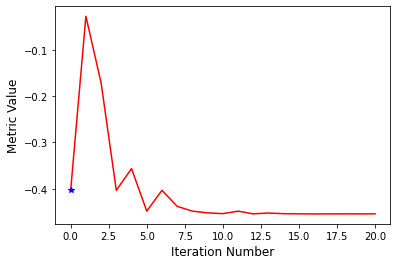

Final metric value: -0.45420666390369785
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 21 iterations. Current step (6.10352e-05) is less than minimum step (0.0001).
rotation, xshift, yshift (-0.11717588892301009, 18.267651595712223, 15.153402267082223)
center (899.1208729778655, 510.0739818061854)


In [54]:
# dk39, 169, 170 have a lot of shift and rotation
# 113, 114
# 137, 138 rotation off
# 192 193 shift off
fixed_index = str(182).zfill(3)
moving_index = str(183).zfill(3)

final_transform, fixed, moving, R = register_test(MASKED, INPUT, fixed_index, moving_index)    

# Always check the reason optimization terminated.
stop_condition = R.GetOptimizerStopConditionDescription()
iterations = R.GetOptimizerIteration()
metric_value = R.GetMetricValue()
finalParameters = final_transform.GetParameters()
fixedParameters = final_transform.GetFixedParameters()

print(f'Final metric value: {metric_value}')
print(f'Optimizer\'s stopping condition, {stop_condition}')
print('rotation, xshift, yshift', finalParameters)
print('center', fixedParameters)

In [27]:
fixed.GetDimension()

2

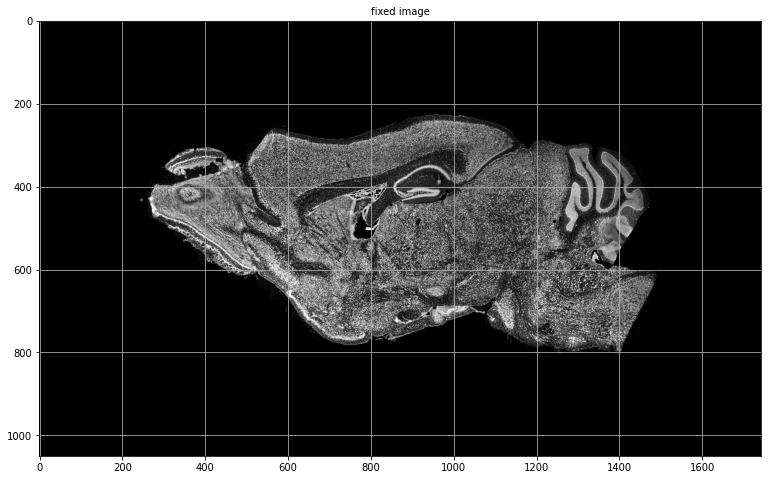

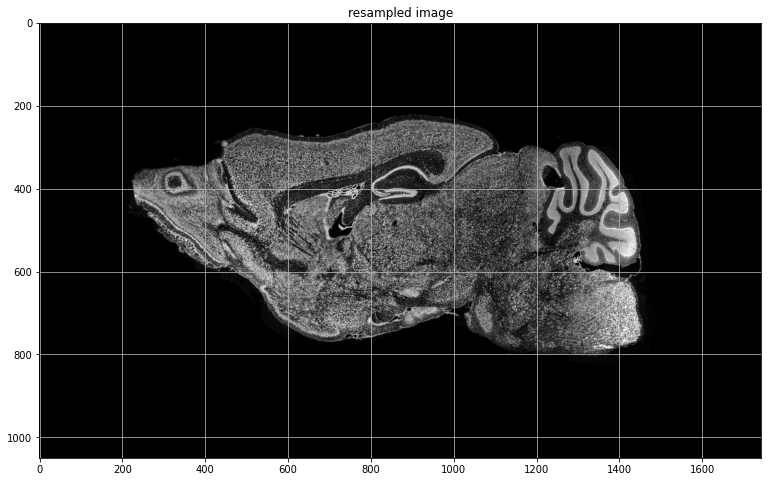

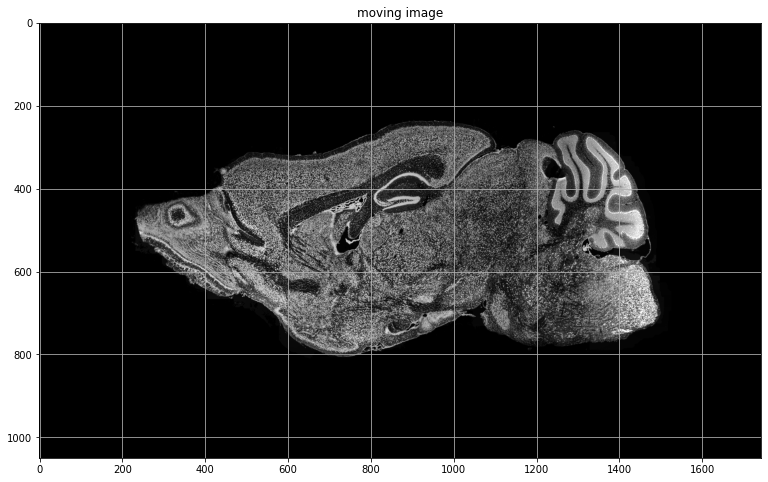

In [52]:
moving_resampled = sitk.Resample(moving, fixed, final_transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
fig = plt.figure(figsize=(15,8))
plt.imshow(sitk.GetArrayViewFromImage(fixed), cmap='gray')
plt.grid()
plt.title('fixed image', fontsize=10)

fig = plt.figure(figsize=(15, 8))
plt.imshow(sitk.GetArrayViewFromImage(moving_resampled), cmap='gray')
plt.grid()
plt.title('resampled image')

fig = plt.figure(figsize=(15, 8))
plt.title('moving image')
plt.grid()
plt.imshow(sitk.GetArrayViewFromImage(moving), cmap='gray')
    